### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle
import itertools
import matplotlib.pyplot as plt

### Data

In [3]:
experiment_name = 'PMG 247 monitoring'

In [4]:
experiment_names = ['Sacharose hydrolysis',
                   'Silane',
                   'PMG 247 monitoring']

In [5]:
results_paths = {'Sacharose hydrolysis': '../results/sacharose_1000/comparing_with_first/known_substrats/',
                'Silane': '../results/silan/comparing_with_first/known_substrats/',
                'PMG 247 monitoring': '../results/PMG_247/comparing_with_first/known_substrats/'
                }

In [6]:
substances_names = {'Sacharose hydrolysis': ['Sacharose', 'Glucose', 'Fructose'],
                    'Silane': [],
                    'PMG 247 monitoring': ['PMG 247']
                   }

### Finding all values of kappa, kappa_th

In [7]:
def convert(txt):
    k = float(txt)
    if k%1 ==0:
        return int(k)
    return k

In [8]:
all_kappas = []
all_kappas_th = []
for file in os.listdir(results_paths[experiment_name]):
    if file.startswith('noise_proportions_in_times'):
        kappa = convert(file.split('_')[4])
        all_kappas.append(kappa)
        kappa_th = convert(file.split('_')[5][:-4])
        all_kappas_th.append(kappa_th)
        
all_kappas = sorted(list(set(all_kappas)))
all_kappas_th = sorted(list(set(all_kappas_th)))

In [9]:
kappas_to_remove = [0.75]
kappas_th_to_remove = [0.75]

In [10]:
all_kappas = sorted(list(set(all_kappas) - set(kappas_to_remove)))
all_kappas_th = sorted(list(set(all_kappas_th) - set(kappas_th_to_remove)))

In [11]:
all_kappas

[0.1, 0.25, 0.5, 1]


### Reading results for different values of kappa, kappa_th

In [12]:
results_dict = {}

for kappa in all_kappas:
    for kappa_th in all_kappas_th:
        try:
            with open(results_paths[experiment_name] + 'proportions_in_times_' +
                                  str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
                y = pickle.load(f)
                y = np.array(y)
                results_dict[(kappa, kappa_th)] = y
        except FileNotFoundError:
            results_dict[(kappa, kappa_th)] = None

### Visualising results

In [13]:
component_nr = 0

In [14]:
lin_regr =False

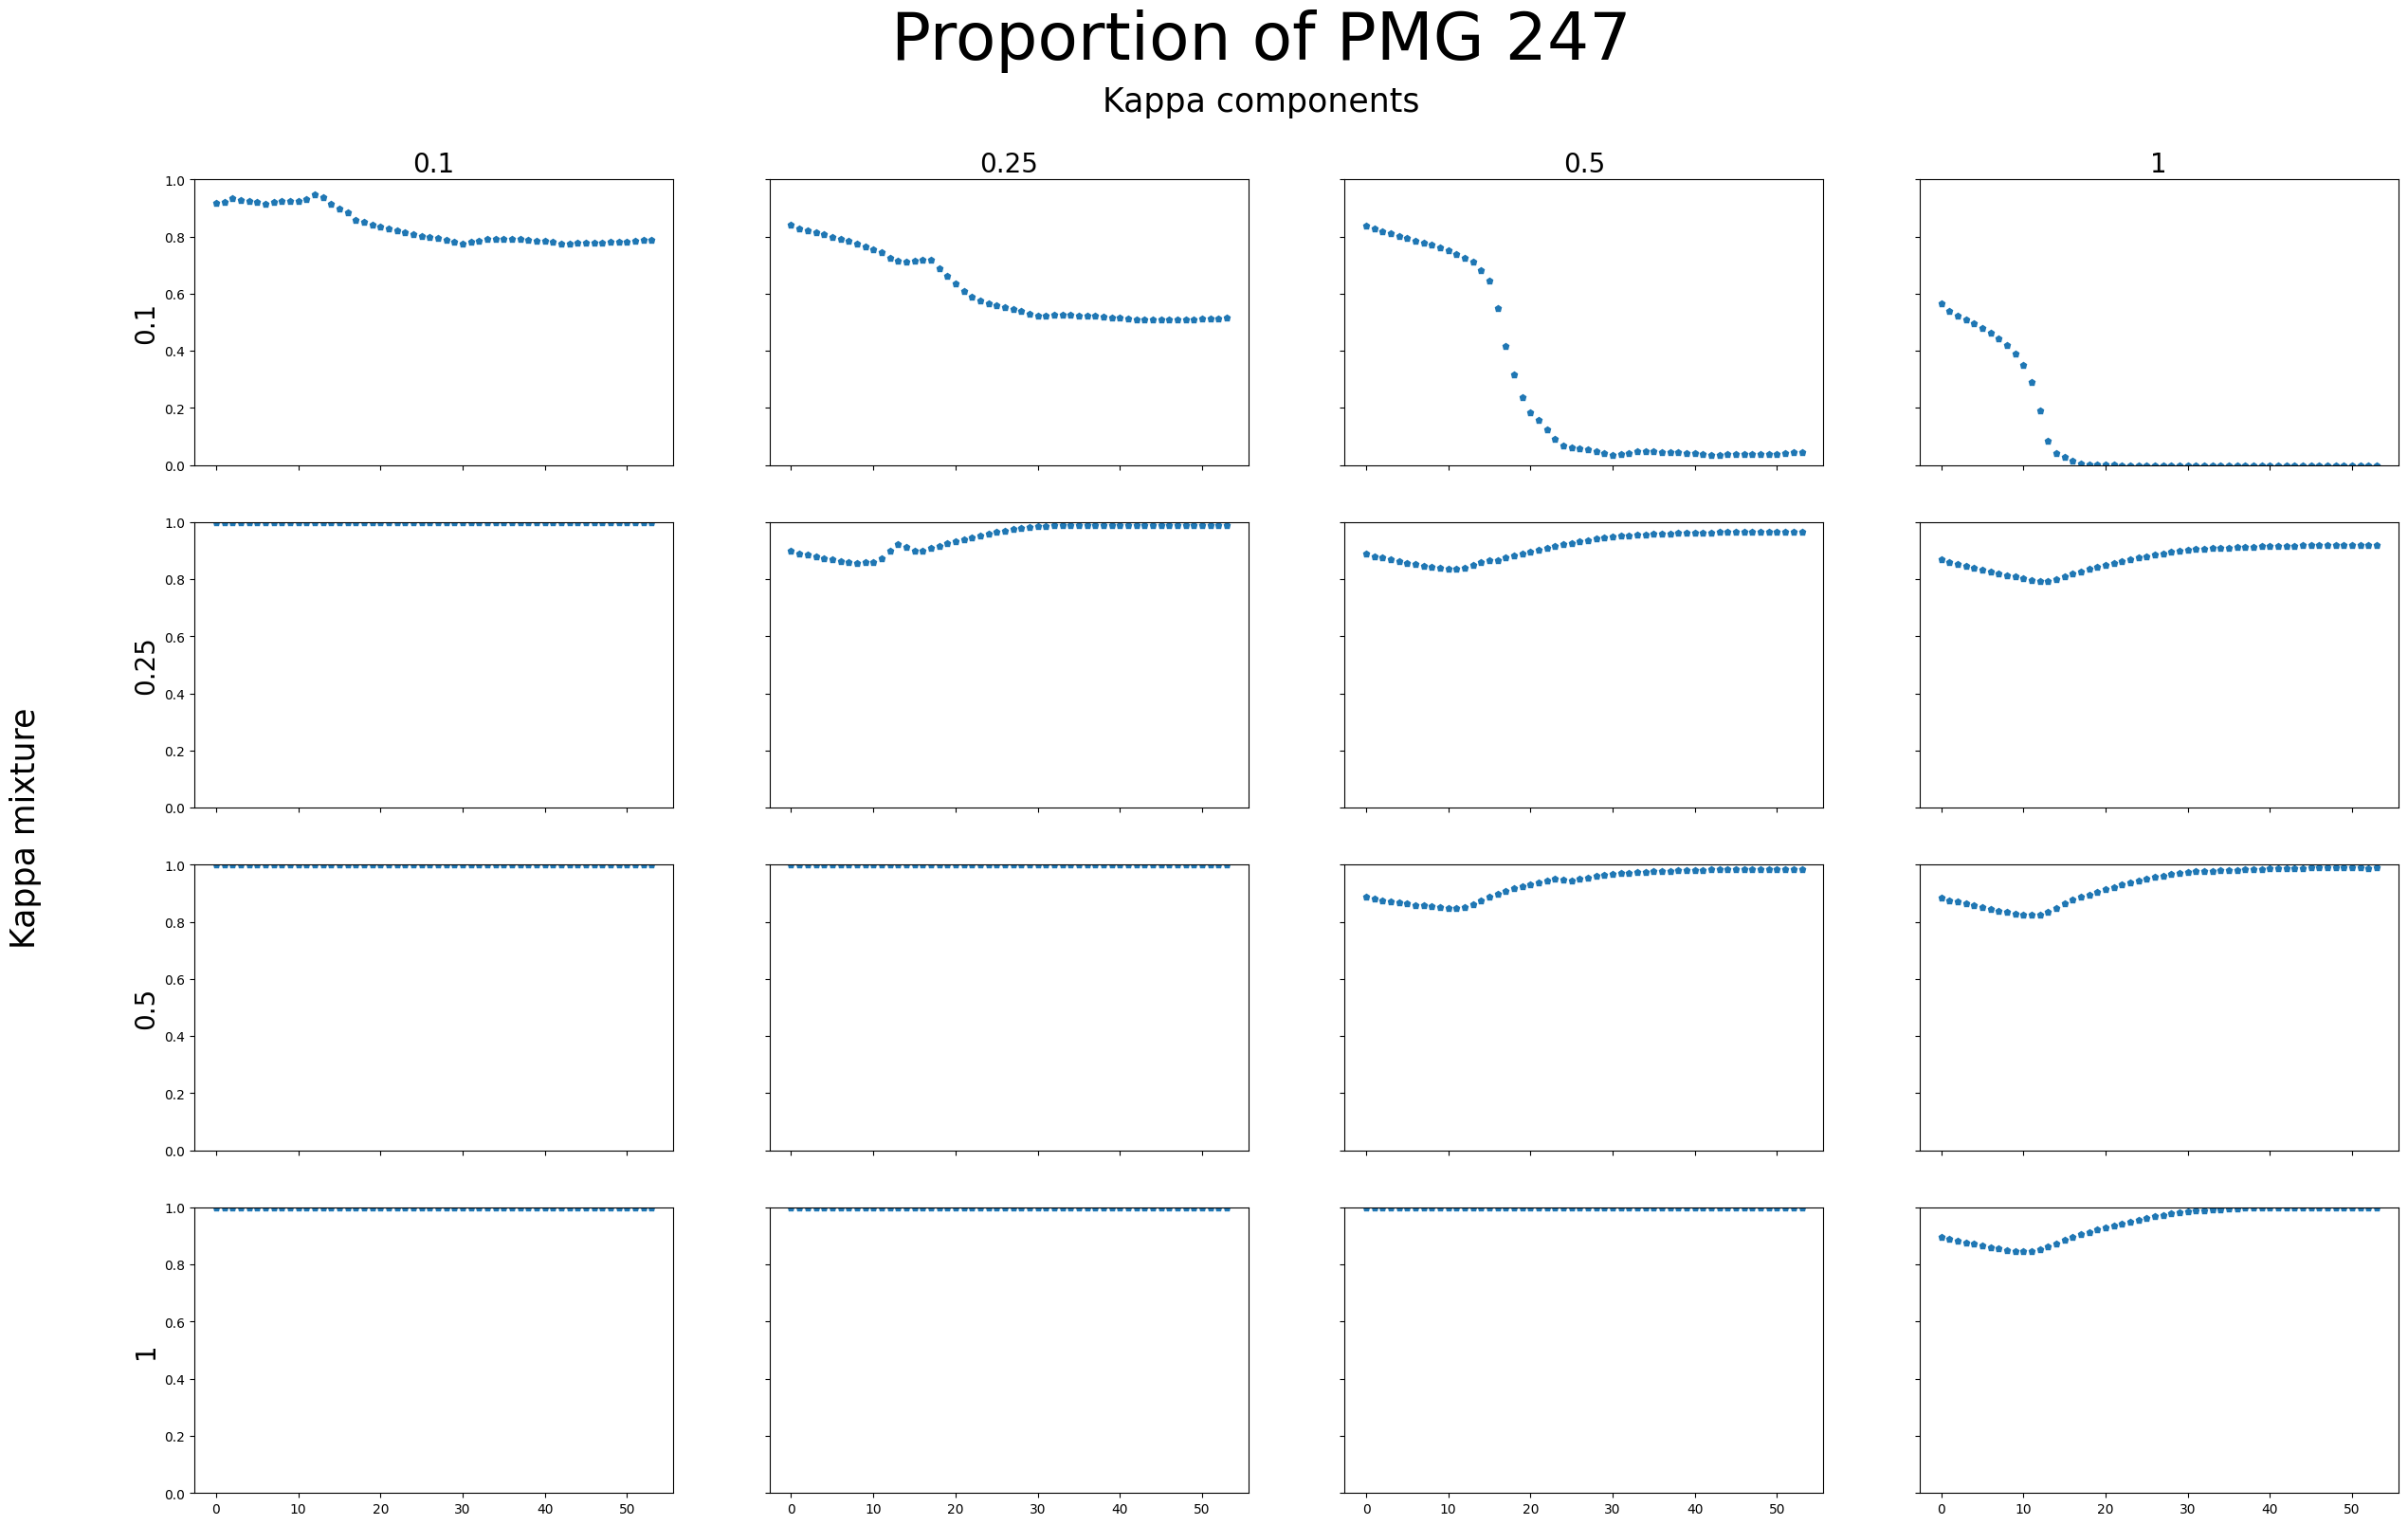

In [15]:
fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of ' + substances_names[experiment_name][component_nr], fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = results_dict[(kappa, kappa_th)][:, component_nr]
            axx.plot(range(len(y)), y, 'p', markersize=5)
            if lin_regr:
                t = np.array(range(1, y.shape[0]+1))
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_'+ substances_names[component_nr]+'.png')

### Products together

In [16]:
products_numbers = [0]
lin_regr =False

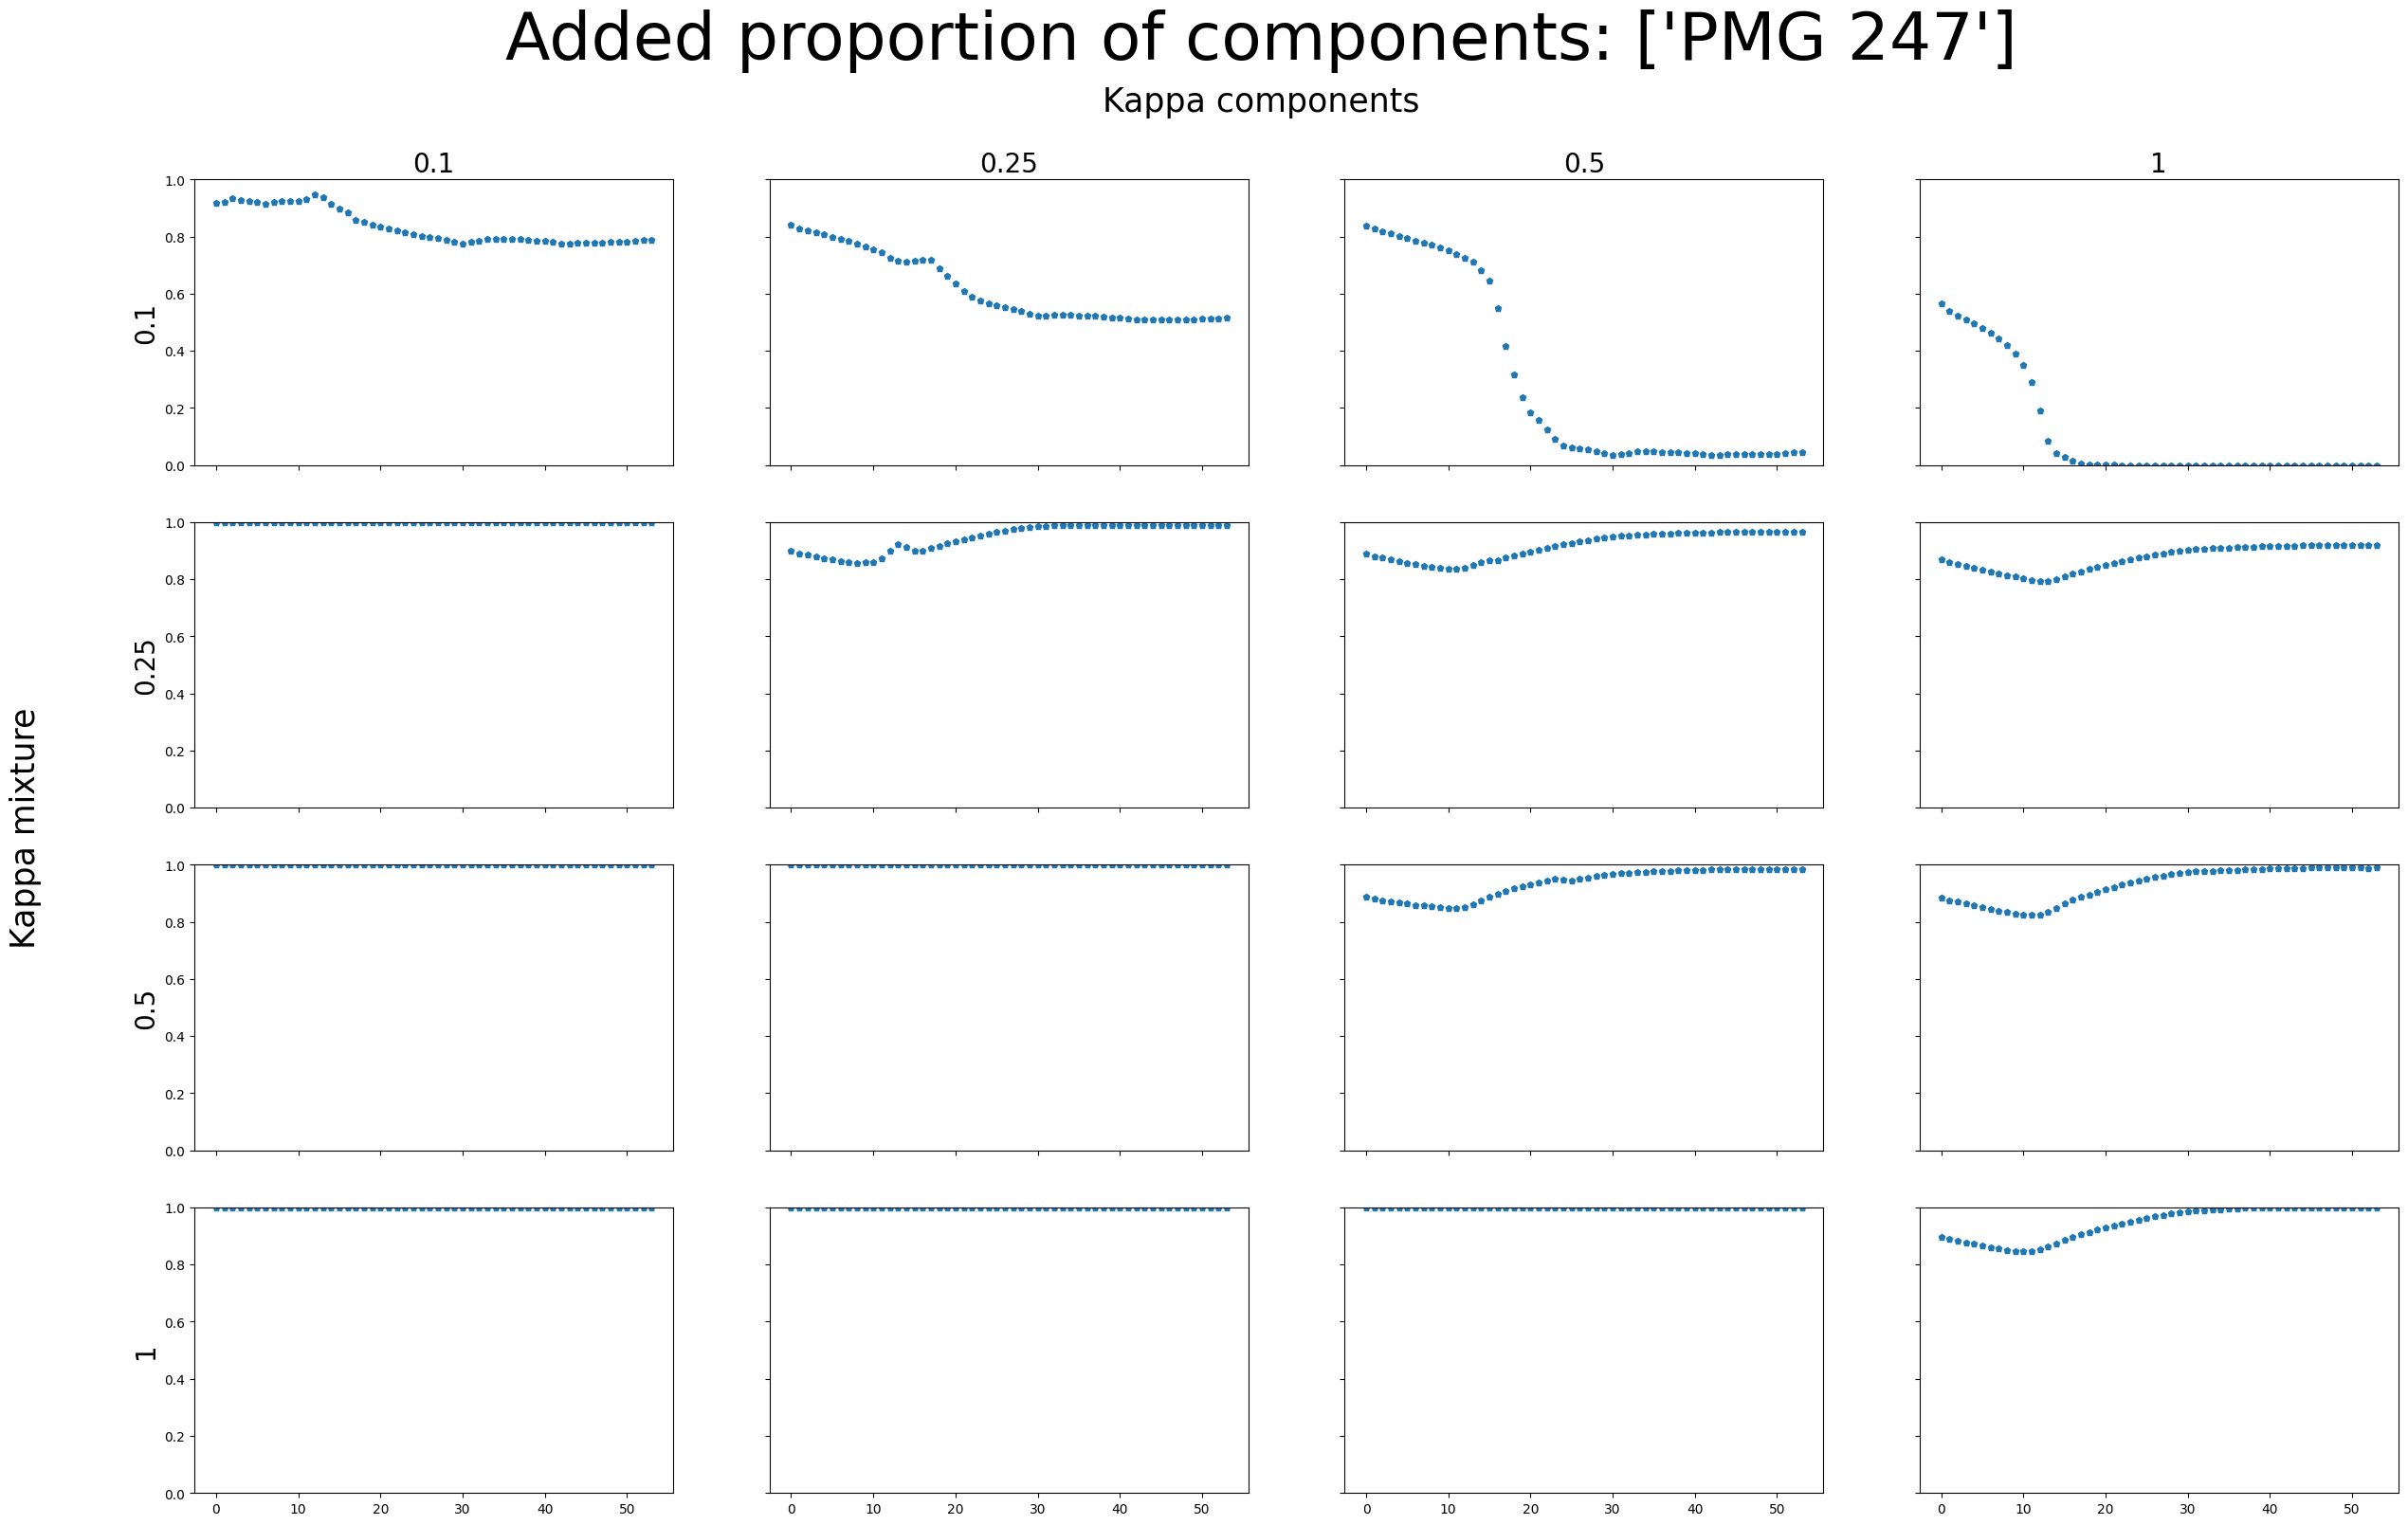

In [17]:
names = [substances_names[experiment_name][nr] for nr in products_numbers]

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Added proportion of components: ' + str(names), fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = 0
            for nr in products_numbers:
                y = y + results_dict[(kappa, kappa_th)][:, nr]
            axx.plot(range(len(y)), y, 'p', markersize=5)
            if lin_regr:
                t = np.array(range(1, y.shape[0]+1))
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_'+ 'Glucose_and_fructose' +'.png')

#### Best one

In [18]:
best_kappa = 0.1
best_kappa_th = 0.5

In [19]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [20]:
component_nr = 0
lin_regr = False

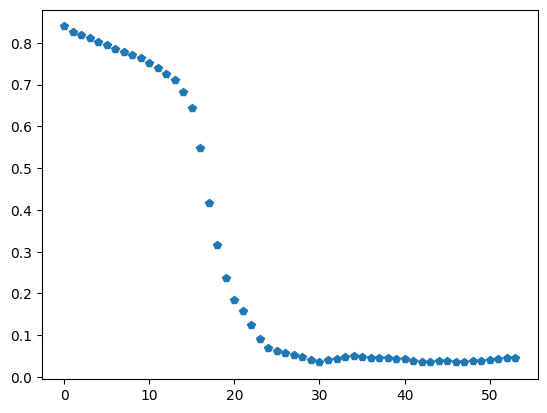

In [21]:
plt.plot(range(len(y)), y[:, component_nr], 'p')
if lin_regr:
    t = np.array(range(1, y.shape[0]+1))
    t_and_ones = np.vstack([t, np.ones(len(t))]).T
    slope, intercept = np.linalg.lstsq(t_and_ones, y[:, component_nr])[0]
    plt.plot(slope*t+intercept)